In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from io import BytesIO
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import itertools
from tqdm.notebook import tqdm

In [2]:
# Check if we have GPU

cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [39]:
# Get data

to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

class ToRGB(nn.Module):
  def forward(self, img):
    return to_tensor(img).tile(dims=(3,1,1))

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=ToRGB())
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

test_data = datasets.MNIST(root='./data', train=False, download=True, transform=ToRGB())
test_loader = DataLoader(test_data, batch_size=4096, shuffle=True)

In [40]:
class Encoder(nn.Module):
    """
    A convolutional encoder.

    For the MNIST dataset this will be:
    3 x 28 x 28 image ->
    16 x 10 x 10 representation ->
    32 x 4 x 4 representation ->
    hidden_size latent space.
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.convolutions = nn.ModuleList([
            nn.Conv2d(3, 16, kernel_size=3, stride=3, padding=1),
            nn.Conv2d(16, 32, kernel_size=3, stride=3, padding=1),
        ])
        conv_size = 32 * ((input_size+8)//9)**2
        self.fc = nn.Linear(conv_size, hidden_size)

    def forward(self, x):
        for conv in self.convolutions:
            x = F.elu(conv(x))
        x = x.view(x.shape[0], -1)
        return torch.tanh(self.fc(x))

class Decoder(nn.Module):
    """
    The reverse process.
    """
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.fc = nn.Linear(hidden_size, 32 * ((output_size+8)//9)**2)
        self.deconvolutions = nn.ModuleList([
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=3, padding=1),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=3, padding=1),
        ])

    def forward(self, x):
        x = F.elu(self.fc(x))
        x = x.view(x.shape[0], 32, 4, 4)
        for deconv in self.deconvolutions:
            x = F.elu(deconv(x))
        return x

In [41]:
def train_autoencoder(encoder, decoder, optim, epochs=10):
  encoder.train()
  decoder.train()

  for epoch in range(epochs):
    total_loss = 0
    pbar = tqdm(train_loader)
    for batch_idx, (img, label) in enumerate(pbar):
      if cuda_available:
        img = img.cuda()

      optim.zero_grad()

      output = decoder(encoder(img))
      loss = F.mse_loss(output, img)

      loss.backward()
      optim.step()

      total_loss += loss.item()
      if batch_idx % 1 == 0:
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(img), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), total_loss / (1 + batch_idx)))

def test_autoencoder(encoder, decoder):
  encoder.eval()
  decoder.eval()

  with torch.no_grad():
    total_loss = 0
    for (img, label) in test_loader:
      if cuda_available:
        img = img.cuda()

      output = decoder(encoder(img))
      loss = F.mse_loss(output, img)
      total_loss += loss.item()

  return total_loss / len(test_loader)

In [42]:
encoder = Encoder(28, 32)
decoder = Decoder(32, 28)
if cuda_available:
  encoder = encoder.cuda()
  decoder = decoder.cuda()

# Train w/ Adam
optim = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()))
train_autoencoder(encoder, decoder, optim, 10)
print(test_autoencoder(encoder, decoder))

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

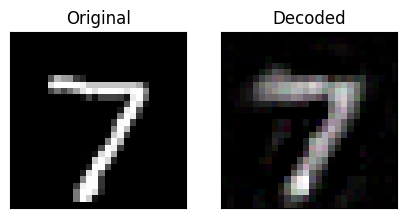

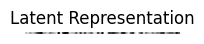

In [52]:
def plot_sample(idx=0):
  x, y = test_data[idx]

  fig, ax = plt.subplots(1, 2, figsize=(5, 10))

  with torch.no_grad():
    z = encoder(x.cuda().unsqueeze(0))
    decoded = decoder(z).squeeze().detach().clip(0, 1).cpu()

  # Plot
  ax[0].set_title("Original")
  ax[1].set_title("Decoded")
  ax[0].imshow(to_pil(x))
  ax[1].imshow(to_pil(decoded))
  ax[0].get_xaxis().set_visible(False)
  ax[1].get_xaxis().set_visible(False)
  ax[0].get_yaxis().set_visible(False)
  ax[1].get_yaxis().set_visible(False)
  plt.show()

  plt.title("Latent Representation")
  fig = plt.figure(figsize=(2, 10))
  plt.gcf().set_size_inches(2, 10)
  plt.axis("off")
  plt.imshow(z.detach().cpu().numpy(), cmap="gray")
  plt.show()
plot_sample()

  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 4
0.06028341377774874


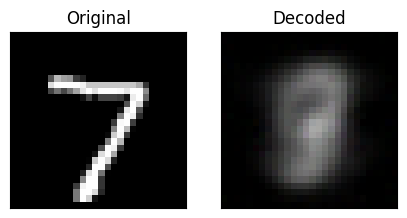

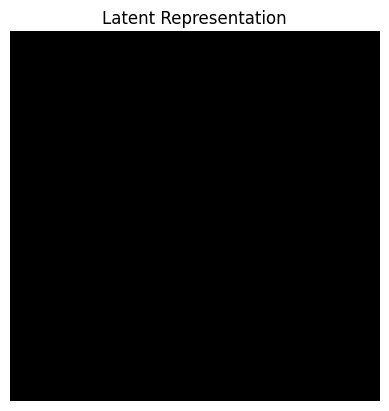

  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 44
0.03305701166391373


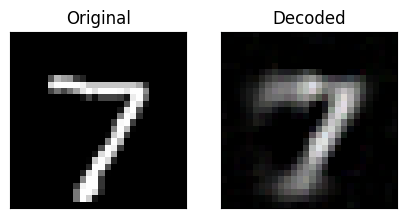

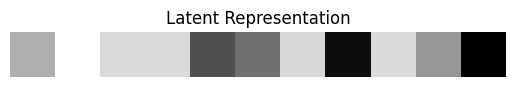

  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 84
0.023287569483121235


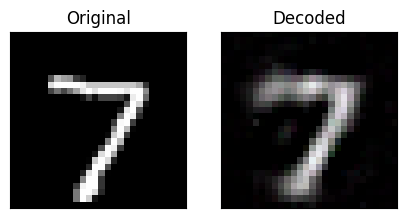

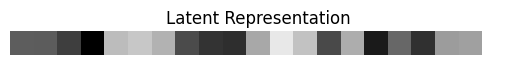

  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 124
0.016953260948260624


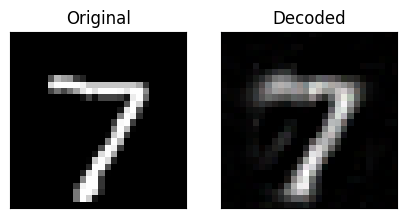

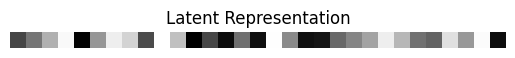

  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 164
0.01681954289476077


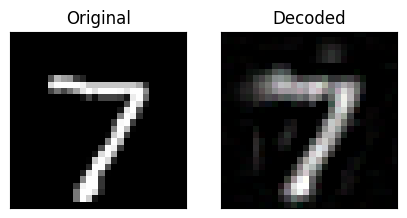

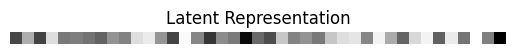

  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 204
0.012476987826327482


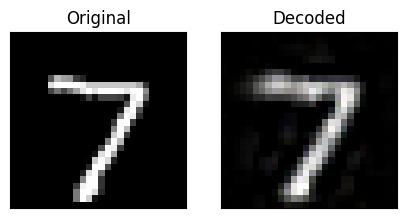

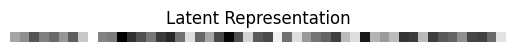

  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 244
0.011209966304401556


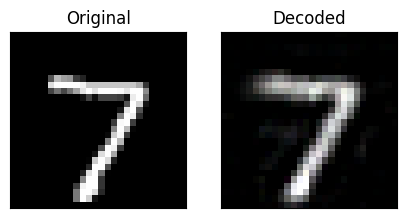

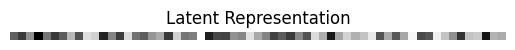

  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
bits = []
loss = []
for dim_size in range(25):
  bits.append(dim_size * 32)
  encoder = Encoder(28, dim_size)
  decoder = Decoder(dim_size, 28)

  if cuda_available:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

  # Train w/ Adam
  optim = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()))
  train_autoencoder(encoder, decoder, optim, epochs=1)
  loss.append(test_autoencoder(encoder, decoder))

  print("BITS =", bits[-1], "LOSS =", loss[-1])
  plot_sample()